Start by copying this into your Google Drive!!

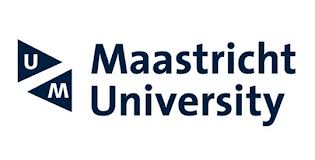
#Faculty of Science and Engineering - Department of Advanced Computer Sciences
# Course Advanced Natural Language Processing - Tutorial Deep Learning and NLP: Transformers

By Jan Scholtes

Welcome to the tutorial on Deep Learning models for NLP. In this notebook you will learn how transformers and BERT models in particular caused a true revolution in NLP.

Ever since the introduction of the Transformer models, it has replaced RNN and LSTM for various NLP tasks. In fact, the success of transformers is so huge, that we will not even look at RNN and LSTM anymore in this tutorial. We did discuss them in the lectures, so you understand why Transformers are as good as they are for NLP tasks and how we got from grammar based NLP systems (via statistical) towards today's Transformers.

The tutorial below is based on code examples from "Natural Language Processing with Transformers" by Lewis Tunstall et al., "Transformers for Natural Language Processing" by Denis Rothman and "Getting Started with Google BERT" by S. Ravichandiran. 

For this notebook we would need our GPU again. You can activate your GPU by clicking on Runtime, then Change runtime type and pressing GPU. If you hit the Google's GPU limits for usage, you can use other free GPU services such as Kaggle GPU's (recommended), Amazon's GPU's or Paperspace Gradient or of course your local GPU on your computer (if you have one).

#Self-Attention
Attention is the mechanism that allows neural networks to assign a different amount of weight or "attention" to each element in a sequence, in the case of natural lanague, such elements are the token embeddings.
Self-attention refers to the mechanism where the attention wieghts are calculated for all hidden states in the same set, e.g. all hidden states in the encoder. 
LSTM's encode the attention of an entire sequence in the last hidden state before it is passed on to the decoder. 

We can visualize how the attention weights are calculated using BertViz. 

  First, enable the GPU under Runtime / Runtime Type

In [ ]:
# !pip install 'lightning-flash[text]' --upgrade   # Run this if you have dependency problems

!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements()

Cloning into 'notebooks'...
remote: Enumerating objects: 507, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 507 (delta 100), reused 100 (delta 87), pack-reused 378
Receiving objects: 100% (507/507), 30.39 MiB | 26.49 MiB/s, done.
Resolving deltas: 100% (236/236), done.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [ ]:
#hide
from utils import *
setup_chapter()

Using transformers v4.11.3
Using datasets v1.16.1


Let's calculate the self-attention for the sentence "time flies like an arrow". For the visualization to unfold, click the + at the left side of the visualization. You will now see the Query Q, Key K and qxk resulting in the softmax values. The intensity corresponds to to the magnitude. In layer 0 and head 8, you can observe, that "flies" has the strongest connection to "arrow". 

In [ ]:
#hide_output
from transformers import AutoTokenizer
from bertviz.transformers_neuron_view import BertModel
from bertviz.neuron_view import show

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BertModel.from_pretrained(model_ckpt)
text = "time flies like an arrow"
show(model, "bert", tokenizer, text, display_mode="light", layer=0, head=8)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

100%|██████████| 440473133/440473133 [00:07<00:00, 61556146.52B/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Let's take a look at an individual transformer instead of the full BERT example from above and investigate the attention mechanism. 

# Tokenize the text

In [ ]:
# hide
from transformers import AutoTokenizer
model_ckpt = "bert-base-uncased"
text = "time flies like an arrow"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


In [ ]:
inputs = tokenizer(text, return_tensors="pt", add_special_tokens=False)
inputs.input_ids

tensor([[ 2051, 10029,  2066,  2019,  8612]])

The sentence is mapped to a sequence of unique tokens, with for each token a unique ID from tha tokenizer's vocabulary. The parameter "add_special_tokens=False" inplies that the special tokens CLS and SEP are not assigned an encoding. 

Next, we need to create some "dense embeddings. "Dense" in this context means that each tokens gets a NON-ZERO value. In PyTorch we can use the code below for the lookups. 

In [ ]:
from torch import nn
from transformers import AutoConfig

config = AutoConfig.from_pretrained(model_ckpt)
token_emb = nn.Embedding(config.vocab_size, config.hidden_size)
token_emb

Embedding(30522, 768)

Embedding(30522, 768} means that each input ID will be mapped to one of the 30.522 embedding vectors stored in nn.Embedding, each with size of 768. Note that in the standard transformers these embeddings are still context-free. So, homonums will have the same encoding. This will be taken care of in the subsequent attention layers, which will disambiguate the different meanings of the word "flies". Now we can generate the embeddings by feeding the input ID's from above. 

In [ ]:
inputs_embeds = token_emb(inputs.input_ids)
inputs_embeds.size()

torch.Size([1, 5, 768])

1 = batch_size, 5 = seq_len and 768 = hidden_dim. Next, let's create the query, key and value vectors and calculate the attention scoresusing the dot product as the similarity function. 

In [ ]:
import torch
from math import sqrt 

query = key = value = inputs_embeds
dim_k = key.size(-1)
scores = torch.bmm(query, key.transpose(1,2)) / sqrt(dim_k)
scores.size()

torch.Size([1, 5, 5])

torch.Size[1,5,5] means that a 5 x 5 matrix of attention scores has been created in this batch. Later, we will see that the weight matrices W-Q, W-K and W-V can be used to set different values for Q, K and V (after training), but for now we will keep them equal. 

Next, let's apply the softmax:

In [ ]:
import torch.nn.functional as F

weights = F.softmax(scores, dim=-1)
weights.sum(dim=-1)

tensor([[1., 1., 1., 1., 1.]], grad_fn=<SumBackward1>)

And multiply the attention weights by the values:

In [ ]:
attn_outputs = torch.bmm(weights, value)
attn_outputs.shape

torch.Size([1, 5, 768])

And we are done. A very simplified form of self-attention. All we did were 2 matrix multiplications and one softmax. One could say that "self-attention" is just a fancy form of averaging the word embeddings of a sequence of tokens. 

We can wrap the above steps in a function that we can use later:

In [ ]:
def scaled_dot_product_attention(query, key, value):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
    weights = F.softmax(scores, dim=-1)
    return torch.bmm(weights, value)

Due to the equal weights for Q anf K, identical words in the context will get very high scores. By re-adjusting the weights for Q and K based on context, we can define different meanings the same (spelling - homonyms) words.  

#Multi-Headed Self Attention

Running multiple attention heads at the same time, allow us to look at all possible context at once. For instance, one head can deal with the subect-verb interaction, and another one finds nearby adjective. This is where the multiple layers come into place. 

Let's first code a single attention head: 

In [ ]:
class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)

    def forward(self, hidden_state):
        attn_outputs = scaled_dot_product_attention(
            self.q(hidden_state), self.k(hidden_state), self.v(hidden_state))
        return attn_outputs

This initializes 3 independent linear layers. For example, BERT has 12 attention heads, so the dimension of each head = 768 / 12 = 64. 

Next, concatenate the outputs of each single attention head which will result in a full multi-headed attention layer:


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
        x = self.output_linear(x)
        return x

Now let's use the same settings as earlier from BERT and pass the Multi-headed attention to the model. 

In [ ]:
multihead_attn = MultiHeadAttention(config)
attn_output = multihead_attn(inputs_embeds)    
attn_output.size() 

torch.Size([1, 5, 768])

And let's visualize the results:

In [ ]:
#hide_output
from bertviz import head_view
from transformers import AutoModel

model = AutoModel.from_pretrained(model_ckpt, output_attentions=True)

sentence_a = "time flies like an arrow"
sentence_b = "fruit flies like a banana"

viz_inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt')
attention = model(**viz_inputs).attentions
sentence_b_start = (viz_inputs.token_type_ids == 0).sum(dim=1)
tokens = tokenizer.convert_ids_to_tokens(viz_inputs.input_ids[0])

head_view(attention, tokens, sentence_b_start, heads=[8])

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

<IPython.core.display.Javascript object>

## Exercise 1: Explain the following:

a) What can be observed form  the multi-headed self-attention?

b) How does this help us in disambiguating the different meanings of the word "flies" in these t examples.

The Multi-head attention finds not only the different words of the sentence, but the different segments of the words, too.
It allows the model to jointly attend to information from different representation subspaces in at different positions.

Multi-head attention gives the Transformer greater power to encode multiple relationships and nuances for each word.
Ιt gives its Attention greater power of discrimination, by combining several similar Attention calculations.

in this example,the word 'flies' appears two times with different meaning and different pos.In the first sentence the word 'flies' is a verb,while in the second is the subject.It is obvious from the visualization as the first word 'flies' is strongly matched with the 'arrow',while the second 'flies' is strongly matched with the 'banana'.
More specifically,as we encode the first word "flies", one attention head is focusing most on "arrow", while another is focusing on "time" In a sense, the model's representation of the word "flies" bakes in some of the representation of both "time" and "arrow".
For the second word 'flies',the first  attention head is focusing most on "banana", while the second "fruit".Therefore,using more than one attention heads helps us understand better the meaning of each word in a sentence.
If we add all the attention heads to the picture, however, things can be harder to interpret.


#The Feed-Forward Layer

The feed-forward sublayer (similar in the endcoder and the decoder) is a simple two layer fully-connected neural network. However, it does not process the entire sequence of token embeddings, it processes each embedding independently. This is also called: "position-wise feed-forward layer", a form of one dimensional convolution with a kernel size of one (if this is new to you: refer to this termonology  to how Convolution works in computer vision). 

Here is the code for the feed forward mechanism:


In [ ]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.linear_1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.linear_2 = nn.Linear(config.intermediate_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        
    def forward(self, x):
        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.linear_2(x)
        x = self.dropout(x)
        return x

Let's forward the attention outputs through the feed-forward layers: 

In [ ]:
feed_forward = FeedForward(config)
ff_outputs = feed_forward(attn_outputs)
ff_outputs.size()

torch.Size([1, 5, 768])

#Adding Layer Normalization

Before we continue, we do need to apply normalization to make sure that each input in the batch have a mean of zero and the same unity variance. 

In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
        self.attention = MultiHeadAttention(config)
        self.feed_forward = FeedForward(config)

    def forward(self, x):
        # Apply layer normalization and then copy input into query, key, value
        hidden_state = self.layer_norm_1(x)
        # Apply attention with a skip connection
        x = x + self.attention(hidden_state)
        # Apply feed-forward layer with a skip connection
        x = x + self.feed_forward(self.layer_norm_2(x))
        return x

And apply this to the input embeddings. 

In [ ]:
encoder_layer = TransformerEncoderLayer(config)
inputs_embeds.shape, encoder_layer(inputs_embeds).size()

(torch.Size([1, 5, 768]), torch.Size([1, 5, 768]))

This whole process has now implemented all aspects of the encoder layer, except for the positional embeddings. 

#Positional Embeddings

In languages, the order of the words and their position in a sentence really matters. The meaning of the entire sentence can change if the words are re-ordered. When implementing NLP solutions, recurrent neural networks have an inbuilt mechanism that deals with the order of sequences. The transformer model, however, does not use recurrence or convolution and treats each data point as independent of the other. Hence, positional information is added to the model explicitly to retain the information regarding the order of words in a sentence. 

In transformers, positional embeddings is done in a really smart way by adding a phase to the embedding, based on a sinus/cosinus transformation as explained in the lecture. 

There are many different ways to do this. Hereunder, we added the code for one of the methods. 

(see https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/ for more code examples)


 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P
 
P = getPositionEncoding(seq_len=4, d=4, n=100)
print(P)

[[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.09983342  0.99500417]
 [ 0.90929743 -0.41614684  0.19866933  0.98006658]
 [ 0.14112001 -0.9899925   0.29552021  0.95533649]]


To understand the positional encoding, let’s start by looking at the sine wave for different positions with n=10,000 and d=512.

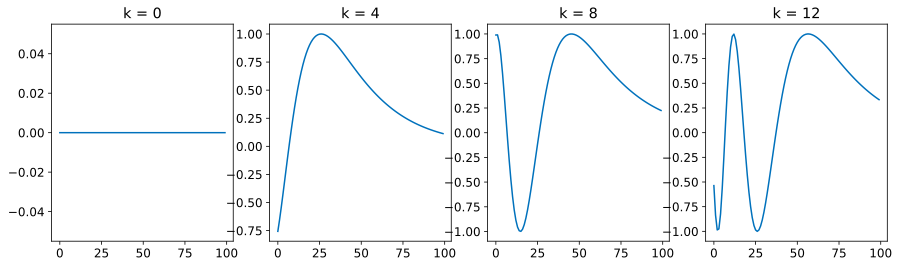

In [ ]:
def plotSinusoid(k, d=512, n=10000):
    x = np.arange(0, 100, 1)
    denominator = np.power(n, 2*x/d)
    y = np.sin(k/denominator)
    plt.plot(x, y)
    plt.title('k = ' + str(k))
 
fig = plt.figure(figsize=(15, 4))    
for i in range(4):
    plt.subplot(141 + i)
    plotSinusoid(i*4)

You can see that each position  corresponds to a different sinusoid, which encodes a single position into a vector. 

Hence, the wavelengths of the sinusoids form a geometric progression and vary from 2 x pi to 2 x pi x n. The scheme for positional encoding has a number of advantages.

The sine and cosine functions have values in [-1, 1], which keeps the values of the positional encoding matrix in a normalized range.
As the sinusoid for each position is different, you have a unique way of encoding each position.
You have a way of measuring or quantifying the similarity between different positions, hence enabling you to encode the relative positions of words.

Let’s visualize the positional matrix on bigger values. Use Python’s matshow() method from the matplotlib library. Setting n=10,000 as done in the original paper, you get the following:

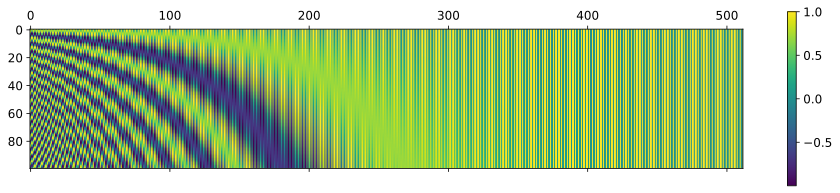

In [ ]:
P = getPositionEncoding(seq_len=100, d=512, n=10000)
cax = plt.matshow(P)
plt.gcf().colorbar(cax)

The positional encoding layer sums the positional vector with the word encoding and outputs this matrix for the subsequent layers. The entire process is shown below.

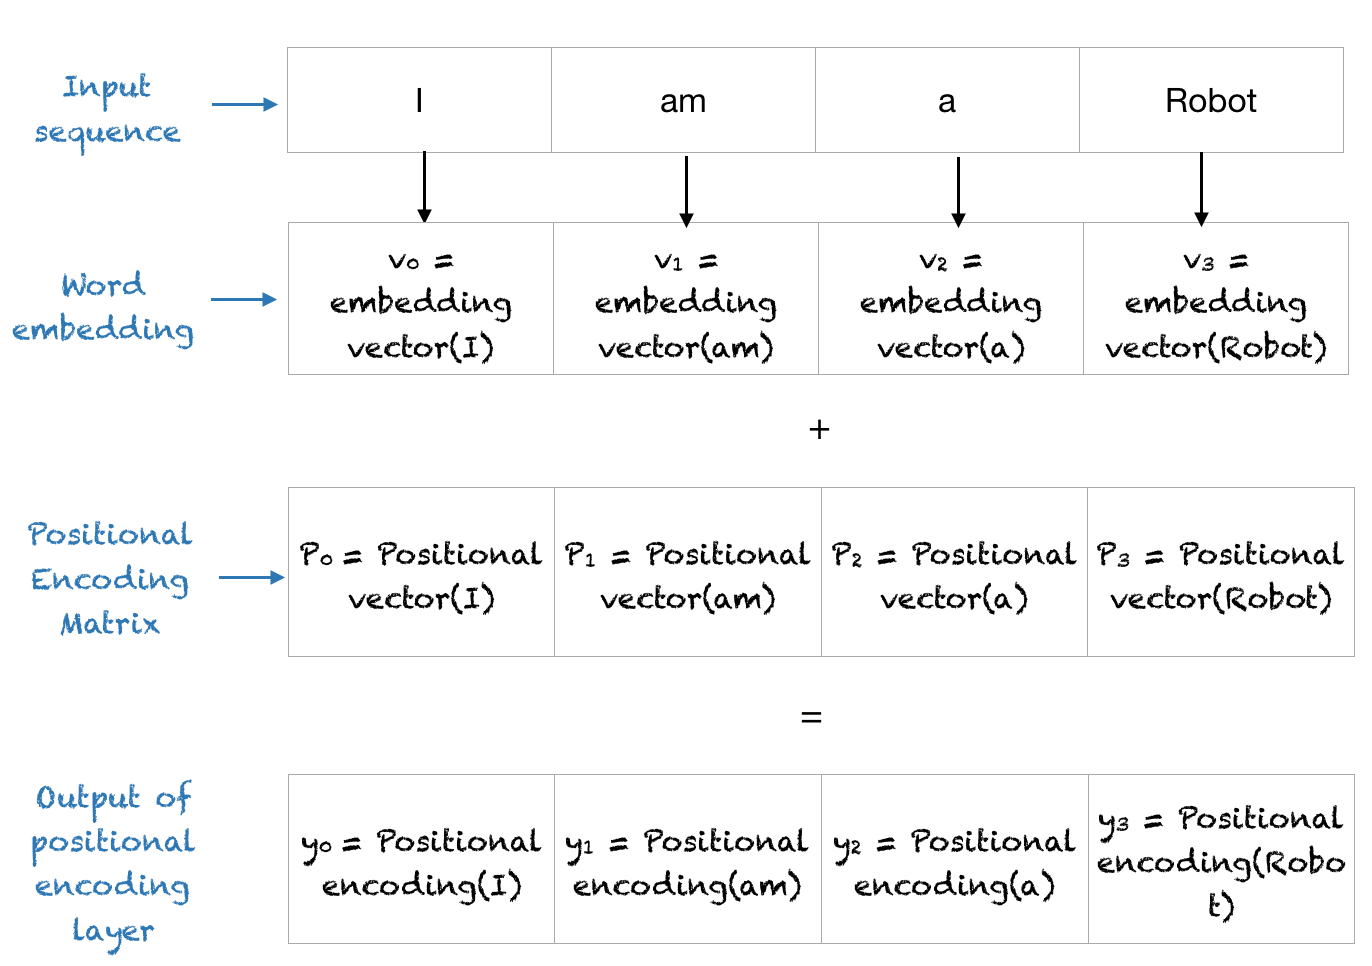

Let's create a class to add positional enciding to our embeddings:

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embeddings = nn.Embedding(config.vocab_size, 
                                             config.hidden_size)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings,
                                                config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout()

    def forward(self, input_ids):
        # Create position IDs for input sequence
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0)
        # Create token and position embeddings
        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        # Combine token and position embeddings
        embeddings = token_embeddings + position_embeddings
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

Let's use this on on the embeddings.

In [ ]:
embedding_layer = Embeddings(config)
embedding_layer(inputs.input_ids).size()

torch.Size([1, 5, 768])

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embeddings = Embeddings(config)
        self.layers = nn.ModuleList([TransformerEncoderLayer(config) 
                                     for _ in range(config.num_hidden_layers)])

    def forward(self, x):
        x = self.embeddings(x)
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
encoder = TransformerEncoder(config)
encoder(inputs.input_ids).size()

torch.Size([1, 5, 768])

This model provides us with a hidden state for each token in the batch. We can use this for many different applications. One of them being a classifier. 

#Adding a Classification Head

In [ ]:
class TransformerForSequenceClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder = TransformerEncoder(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        
    def forward(self, x):
        x = self.encoder(x)[:, 0, :] # select hidden state of [CLS] token
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [ ]:
config.num_labels = 3
encoder_classifier = TransformerForSequenceClassification(config)
encoder_classifier(inputs.input_ids).size()

torch.Size([1, 3])

## Exercise 2: 

Explain how an encoder with a classifier head can be used as POS tagger? 

No need to submit any code yet, we will do that in the second part of the tutorial (BERT part)


YOUR ANSWERS HERE
We could have acquired the sentence features through the last layer and then just run a Logistic regression classifier on top or take an average of all the outputs and then run a logistic regression on top.
Generally use a method that consists of an embedding layer which projects words to vectors and a linear model which predicts POS tags from those vectors.
Part-of-speech tagging is addressed
with a transformer encoder model with a token classification head on top. The transformer, first, returns contextual embeddings of each token.Next, a linear layer
with softmax activation returns normalized scores for
each tag seen in training.

#The Decoder

In [ ]:
seq_len = inputs.input_ids.size(-1)
mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)
mask[0]

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])

In [ ]:
scores.masked_fill(mask == 0, -float("inf"))

tensor([[[28.1443,    -inf,    -inf,    -inf,    -inf],
         [ 0.9706, 27.9244,    -inf,    -inf,    -inf],
         [ 1.3305,  0.6601, 29.7147,    -inf,    -inf],
         [-2.0743, -0.2202,  0.6054, 27.9600,    -inf],
         [ 2.2567,  1.4871, -0.4215, -1.2176, 27.7475]]],
       grad_fn=<MaskedFillBackward0>)

In [ ]:
def scaled_dot_product_attention(query, key, value, mask=None):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float("-inf"))
    weights = F.softmax(scores, dim=-1)
    return weights.bmm(value)

## Exercise 3: 

a) There are many different strategies for decoding in Transformers. Can you name 3 different strategies?

b) Explain for each of these 3 the advantages and disadvantages.

c) Write example code to apply each of these 3 different strategies.  

YOUR ANSWERS HERE
a)Greedy Search, Beam search, Top-K sampling 

b)**Greedy search** simply selects the word with the **highest** **probability** as its next word...Advantages:It produces reasonable sequences.
Disantvantages:It misses high probability words hidden behind a low probability word.Therefore, it does not always generate optimal output sequences.
For longer sentences,this method is often getting stuck on a particular word or sentence and repetitively assigning these sets of words the highest probability again and again.

**Beam Search**
Beam search has a parameter called beam_size. The beam_size is the number of tokens with the highest conditional probabilities at each time step t.
Advantages:Beam search reduces the risk of missing hidden high probability word sequences by keeping the most likely beam_size of hypotheses at each time step and eventually choosing the hypothesis that has the **overall highest probability**.
Another important feature about Beam Search is that we can compare the top beams after generation and choose the generated beam that fits our purpose best.
Disantvantage:Beam search heavily suffers from repetitive generation.Increasing the beam_size, the quality of the output sequence improves significantly, but it reduces the decoder speed.
Beam search can work very well in tasks where the length of the desired generation is more or less predictable as in machine translation or summarization. But this is not the case for open-ended generation where the desired output length can vary greatly, e.g. dialog and story generation.Beam search will always find an output sequence with higher probability than greedy search, but is not guaranteed to find the most likely output.

**Top k sampling**
Sampling means randomly picking the next word according to its conditional probability distribution. In Top-K sampling, the K most likely next words are filtered and the probability mass is redistributed among only those K next words.
Advantages:This method produces more fluent text on open ended language generation.
Disantvantages:Language generation using sampling is not deterministic.The model often generate incoherent gibberish.

In [ ]:
#YOUR CODE HERE
#Greed Search

from transformers import GPT2LMHeadModel, GPT2Tokenizer
tokenizer=GPT2Tokenizer.from_pretrained('gpt2')
model=GPT2LMHeadModel.from_pretrained('gpt2')

input_ids = tokenizer.encode('Today is a good day', return_tensors='pt')
greedy_output = model.generate(input_ids, max_length=200)
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True))
#From the output we observe that the generated sentence is reasonable but it is repeated.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Today is a good day for the world.

The world is a better place.

The world is a better place.

The world is a better place.

The world is a better place.

The world is a better place.

The world is a better place.

The world is a better place.

The world is a better place.

The world is a better place.

The world is a better place.

The world is a better place.

The world is a better place.

The world is a better place.

The world is a better place.

The world is a better place.

The world is a better place.

The world is a better place.

The world is a better place.

The world is a better place.

The world is a better place.

The world is a better place.




In [ ]:
#Top-K Sampling
sample_output = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=200, 
    top_k=50
)

print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Today is a good day in history."


"I think she will get her moment. As many of you know, it's not as bad as it has been in this election cycle, but that's what she will have to fight against," Rubio said. "If she gets her opportunity, it will be great for me and my family. If there is a place in America where there is a person like that, that's where I would prefer to be."


Rubio has long been pushing hard for a Rubio presidency. But he recently indicated he could no longer stay in the race. He was speaking at a fundraiser in Cedar Rapids, Iowa.


In [ ]:
#Beam search
# activate beam search and early_stopping
beam_output = model.generate(
    input_ids, 
    max_length=200, 
    num_beams=5, 
    early_stopping=True
)

print(tokenizer.decode(beam_output[0], skip_special_tokens=True))
#Sentence is repeated.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Today is a good day for all of us, and a good day for all of you," he said.

"It's a good day for all of us, and a good day for all of you," he said.

"It's a good day for all of us, and a good day for all of you," he said.

"It's a good day for all of us, and a good day for all of you," he said.

"It's a good day for all of us, and a good day for all of you," he said.

"It's a good day for all of us, and a good day for all of you," he said.


# More Transformer Details

The recent ["Attention is All You Need"] (https://arxiv.org/abs/1706.03762) paper from NIPS 2017 introduced Transformers. Here: https://nlp.seas.harvard.edu/2018/04/03/attention.html you can find an excellent tutorial that takes you through the paper, step by step, using a python tutorial on Colab: https://drive.google.com/file/d/1xQXSv6mtAOLXxEMi8RvaW8TW-7bvYBDF/view. We highly recommend that you go through the paper by using this tuturial yourself to fully understand the inner-workings of transformers. 

## Exercise 4: Any reflexions on Transformers and on the Harvard Tutorial in particular?


Transformers can be considered as an Encoder-Decoder model, where the Encoder will take our inputs and convert them to a vector. These encoded inputs are given to the Decoder, where the Decoder tries to convert the vector into a Natural language, or an interpretable language. 
Transformers improved the machine translation because they use non-sequential processing.Sentences are processed as a whole, rather than word by word.
They improved a lot of tasks like sentiment analysis,question answering,sequence classification,named entity recognition,speach recognition etc. 

YOUR ANSWER HERE

# BREAK

After the break, continue with the second part of this tutorial (BERT): https://colab.research.google.com/drive/16hT3ZgRHslOPoPO-wKZ7gZr0Wy4TCbnZ 